<a href="https://colab.research.google.com/github/mx60s/predictive-coding-thesis/blob/north-facing/LatentAnalyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze latent variables for head dir, shifters, etc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.5 MB/s eta 0:00:00


In [1]:
#%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
torch.manual_seed(321)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda device
/home/mag/predictive-coding-thesis/src


### Generate latents, post prediction (at least for non-autoencoder) for all samples

In [3]:
use_headings = False
predictions = False    # if we want to get predictive latents

# I still need to work on the non-predictive because that's messed up with the headings right now
# I'd need to retrain the predictive coder model so that the displacements are not futuristic + added disp at end


# okay so currently noticing that post-attention latents aren't giving nice little place fields like you'd hope
# examine pre-attention latents and keep in mind that you're expecting they won't encode place as much

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

data_dir = 'data/face-north'

if predictions:
    if use_headings:
        dataset = HeadingPredCoordDataset(source_directory=data_dir, seq_len=7, transform=transform)
    else: # not sure about this one lol
        dataset = SequentialFrameDataset(source_directory=data_dir, seq_len=7,
                                         transform=transform)
else:
    dataset = CoordinateDataset(source_directory=data_dir, transform=transform, num_samples=80000)


print(f'{len(dataset)} samples')

batch_size = 16 # if predictions else 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

['coords_random_facenorth_2024-01-05-01-22-49.npy', 'coords_random_facenorth_2024-01-05-02-00-51.npy', 'coords_random_facenorth_2024-01-05-02-09-17.npy', 'coords_random_facenorth_2024-01-05-03-30-10.npy', 'coords_random_facenorth_2024-01-05-04-20-03.npy', 'coords_random_facenorth_2024-01-05-04-28-28.npy', 'coords_random_facenorth_2024-01-05-04-47-21.npy', 'coords_random_facenorth_2024-01-05-04-55-47.npy', 'coords_random_facenorth_2024-01-05-05-04-34.npy', 'coords_random_facenorth_2024-01-05-05-12-57.npy', 'coords_random_facenorth_2024-01-05-05-21-24.npy', 'coords_random_facenorth_2024-01-05-05-30-49.npy', 'coords_random_facenorth_2024-01-05-05-39-15.npy', 'coords_random_facenorth_2024-01-05-05-47-44.npy', 'coords_random_facenorth_2024-01-05-05-56-36.npy', 'coords_random_facenorth_2024-01-05-06-19-21.npy']
80000 samples


In [5]:
"""
if predictions:
    if use_headings:
        model_file = 'faceforward_88143_samples-200ep-causal.pt'
        model = PredictiveCoderWithHead()
    else:
        model_file = 'facenorth_71884_samples-200ep-causal.pt'
        model = PredictiveCoder()
else:
    model_file = 'autoencoder-facenorth_72000_samples-200ep.pt'
    model = AutoEncoder()
"""
# whatever
model_file = 'facenorth_71884_samples-200ep-causal.pt'
model = PredictiveCoder()

model.to(device)
model.load_state_dict(torch.load('model_files/' + model_file))
model.eval()
for param in model.parameters():
    param.requires_grad = False


In [5]:
seq, pred = next(iter(loader))
frames, heading = seq
print(heading)
print(pred)

ValueError: too many values to unpack (expected 2)

In [6]:
latent_preds = []
pred_coords = []

latent_save_file = f'data/latents/{model_file[:-3]}.npy'
pred_coords_save_file = f'data/latents/coords-{model_file[:-3]}.npy'

with torch.no_grad():
    for seq, pred in loader:
        if predictions:
            if use_headings:
                frames, headings = seq[0].to(device), seq[1].to(device)
                latents = model.get_latent_preds(frames, headings)
            else:
                frames = seq.to(device)
                latents = model.get_latent_preds(frames)
        else:
            frames = seq.to(device)
            latents = model.get_latents(frames)
    
        latent_preds.append(latents)
        pred_coords.append(pred)


latent_preds = [latent.cpu().numpy() for latent in latent_preds]
pred_coords = [pred.numpy() for pred in pred_coords]

latents_unrolled = np.concatenate(latent_preds, axis=0)
preds_unrolled = np.concatenate(pred_coords, axis=0)

np.save(latent_save_file, latents_unrolled)
np.save(pred_coords_save_file, preds_unrolled)

### Run t-SNE on latent variables

In [7]:
#model_file = 'autoencoder-facenorth_72000_samples-200ep.pt' #'faceforward_noisy_83143_samples-200ep-causal.pt'

latent_save_file = f'data/latents/{model_file[:-3]}.npy'
pred_coords_save_file = f'data/latents/coords-{model_file[:-3]}.npy'

latents = np.load(latent_save_file)
pred_coords = np.load(pred_coords_save_file)

In [8]:
import pandas as pd
from sklearn.manifold import TSNE

df = pd.DataFrame(pred_coords, columns=['x', 'y', 'yaw'])

subset_indices = np.random.choice(latents.shape[0], 40000, replace=False)
latents_subset = latents[subset_indices]
df_subset = df.iloc[subset_indices]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, random_state=42)
tsne_results = tsne.fit_transform(latents_subset)

/tmp/ipykernel_1227734/3536725679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['xy_magnitude'] = np.sqrt(df_subset['x']**2 + df_subset['y']**2)


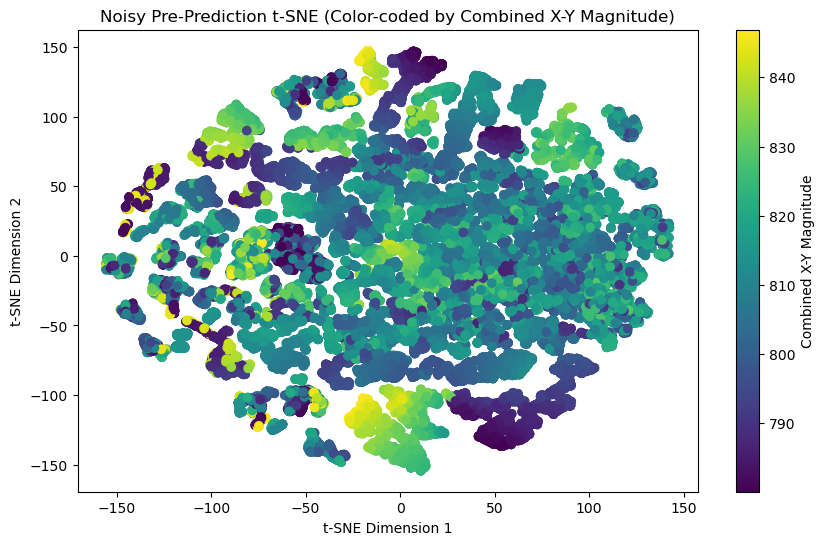

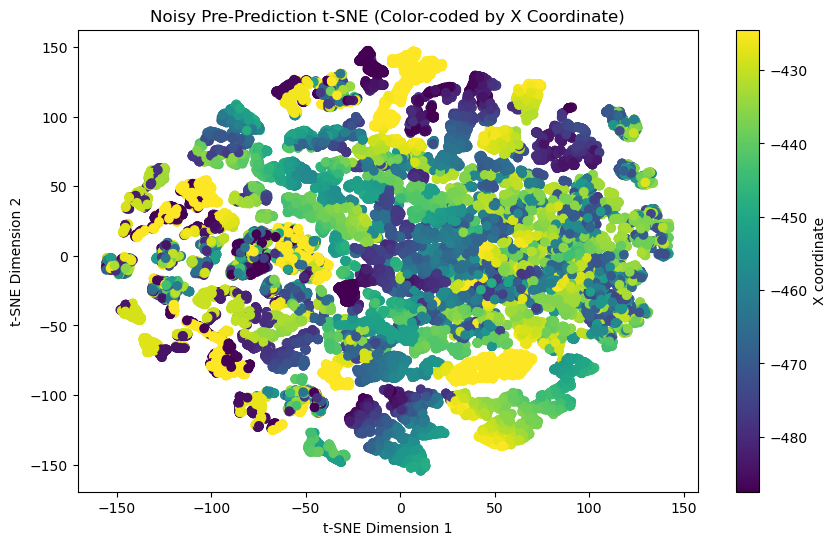

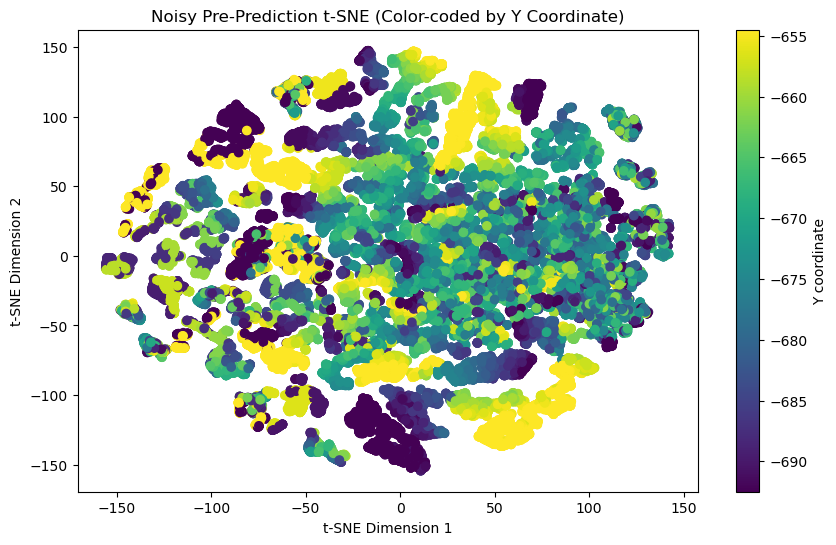

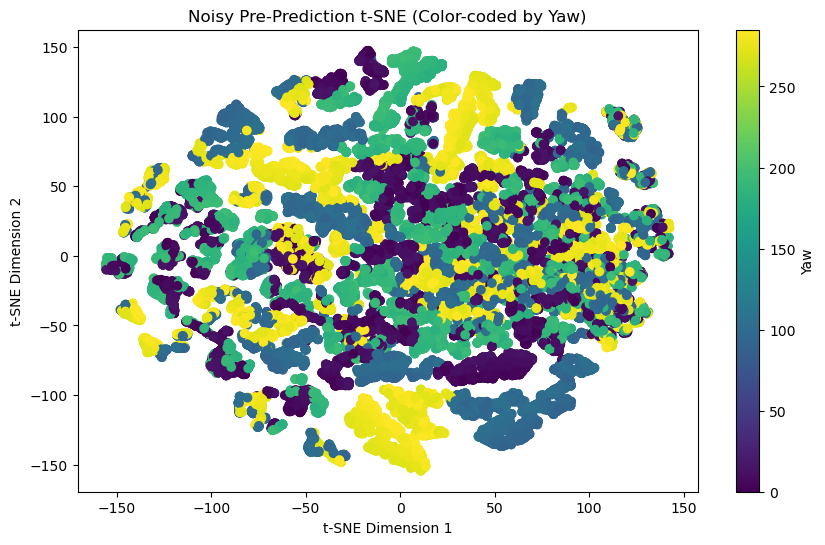

In [9]:
df_subset['xy_magnitude'] = np.sqrt(df_subset['x']**2 + df_subset['y']**2)

plt.figure(figsize=(10, 6))
# Use the 'xy_magnitude' column for coloring
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['xy_magnitude'], cmap='viridis')
plt.colorbar(sc, label='Combined X-Y Magnitude')
plt.title('Noisy Pre-Prediction t-SNE (Color-coded by Combined X-Y Magnitude)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

plt.savefig('noisy-pre-pred-tsne-xy.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

plt.figure(figsize=(10, 6))
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['x'], cmap='viridis')
plt.colorbar(sc, label='X coordinate')
plt.title('Noisy Pre-Prediction t-SNE (Color-coded by X Coordinate)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
plt.savefig('noisy-pre-pred-tsne-x.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

plt.figure(figsize=(10, 6))
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['y'], cmap='viridis')
plt.colorbar(sc, label='Y coordinate')
plt.title('Noisy Pre-Prediction t-SNE (Color-coded by Y Coordinate)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
plt.savefig('noisy-pre-pred-tsne-y.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

plt.figure(figsize=(10, 6))
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['yaw'], cmap='viridis')
plt.colorbar(sc, label='Yaw')
plt.title('Noisy Pre-Prediction t-SNE (Color-coded by Yaw)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
plt.savefig('noisy-pre-pred-tsne-yaw.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()


In [10]:
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, n_iter=2000, random_state=42)
tsne_results_3d = tsne_3d.fit_transform(latents_subset)


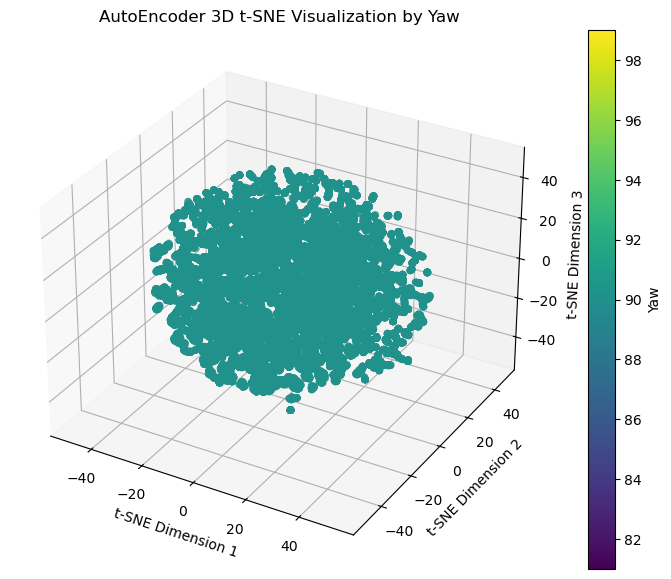

In [11]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # Set up a 3D subplot

# Scatter plot for 3D t-SNE results
sc = ax.scatter(tsne_results_3d[:, 0], tsne_results_3d[:, 1], tsne_results_3d[:, 2], c=df_subset['yaw'], cmap='viridis')

# Add color bar and labels
plt.colorbar(sc, ax=ax, label='Yaw')
ax.set_title('AutoEncoder 3D t-SNE Visualization by Yaw')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.show()
plt.savefig('autoencoder-tsne-3d-yaw-40000.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

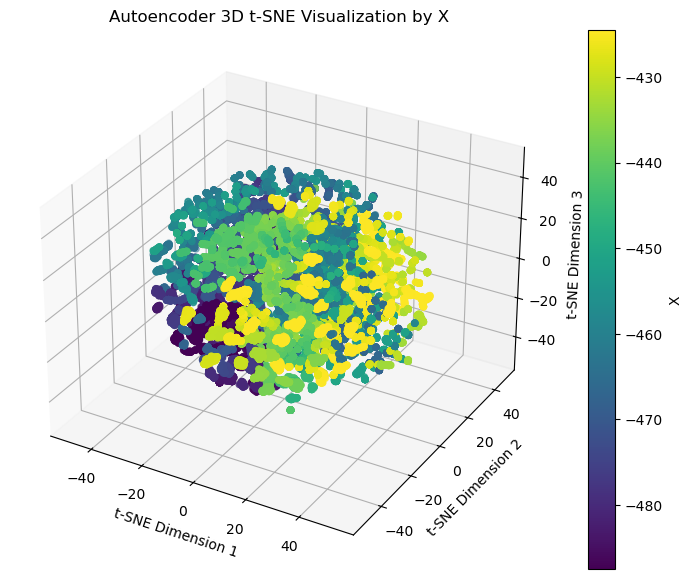

In [12]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # Set up a 3D subplot

# Scatter plot for 3D t-SNE results
sc = ax.scatter(tsne_results_3d[:, 0], tsne_results_3d[:, 1], tsne_results_3d[:, 2], c=df_subset['x'], cmap='viridis')

# Add color bar and labels
plt.colorbar(sc, ax=ax, label='X')
ax.set_title('Autoencoder 3D t-SNE Visualization by X')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.savefig('autoencoder-tsne-3d-x-40000.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.show()

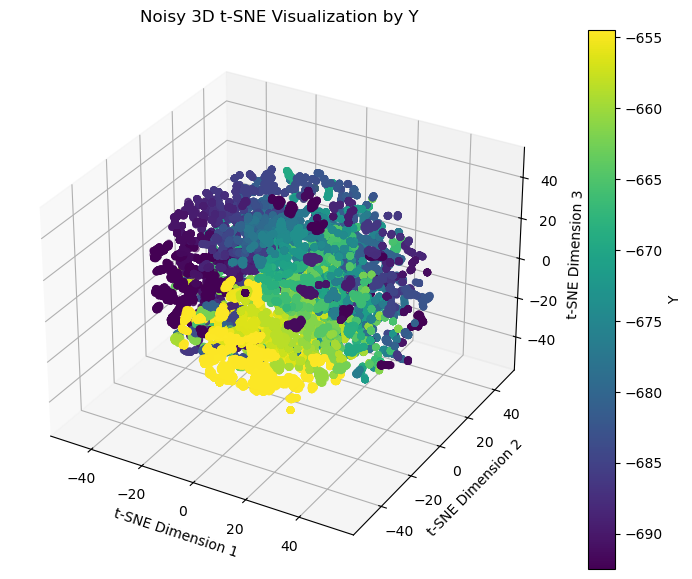

In [13]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # Set up a 3D subplot

# Scatter plot for 3D t-SNE results
sc = ax.scatter(tsne_results_3d[:, 0], tsne_results_3d[:, 1], tsne_results_3d[:, 2], c=df_subset['y'], cmap='viridis')

# Add color bar and labels
plt.colorbar(sc, ax=ax, label='Y')
ax.set_title('Noisy 3D t-SNE Visualization by Y')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.savefig('autoencoder-tsne-3d-y-40000.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.show()
plt.close()

## PCA analysis

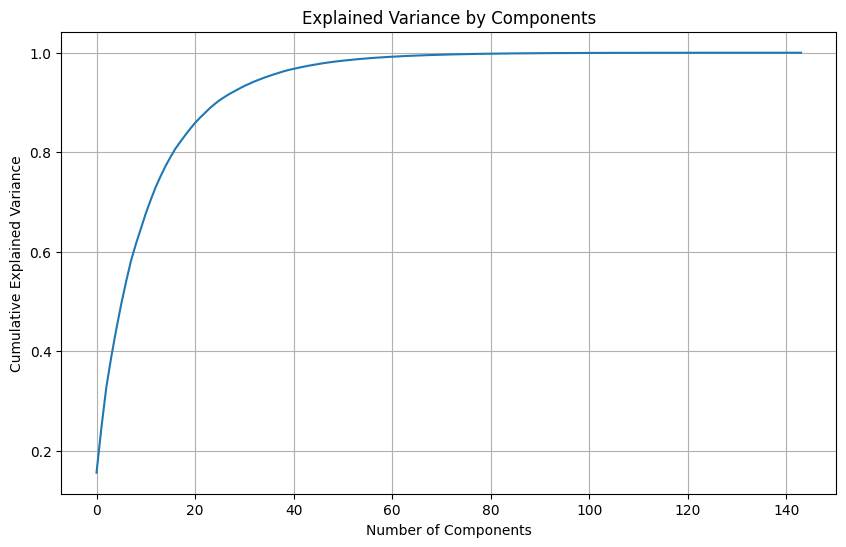

Number of components to keep for 95% variance: 36


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
latents_standardized = scaler.fit_transform(latents_subset)

pca = PCA()
pca.fit(latents_standardized)

latents_pca = pca.transform(latents_standardized)

# Step 6: Examine the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Decide the number of components to keep and transform the data
# For example, to keep 95% of variance, find where cumulative explained variance reaches 0.95
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1
print(f"Number of components to keep for 95% variance: {n_components}")

# Re-run PCA with the desired number of components
pca = PCA(n_components=n_components)
latents_pca_reduced = pca.fit_transform(latents_standardized)

# Now, 'latents_pca_reduced' is your dataset transformed to the principal component space with reduced dimensionality


## Thresholding Activations

In [59]:
model_file = 'faceforward_noisy_83143_samples-200ep-causal.pt'

latent_save_file = f'data/latents/{model_file[:-3]}.npy'
pred_coords_save_file = f'data/latents/coords-{model_file[:-3]}.npy'

all_latents = np.load(latent_save_file)
pred_coords = np.load(pred_coords_save_file)

num_latents = all_latents.shape[1]

thresholds = np.zeros(num_latents)
for i in range(num_latents):
    thresholds[i] = np.percentile(all_latents[:,i], 95, axis=0)

activations_dict = [[] for _ in range(num_latents)]

for latents, coords in zip(all_latents, pred_coords):
    activations = (latents >= thresholds)
    for i, active in enumerate(activations):
        if active:
            activations_dict[i].append(tuple(coords))


def get_activations(latents):
    coords = []
    activations = (latents >= thresholds)
    for i, active in enumerate(activations):
        if active:
            coords += activations_dict[i]

    return coords


In [60]:
print(pred_coords.shape)

(84000, 3)


Actual coords: [-475.5 -679.5  189. ]


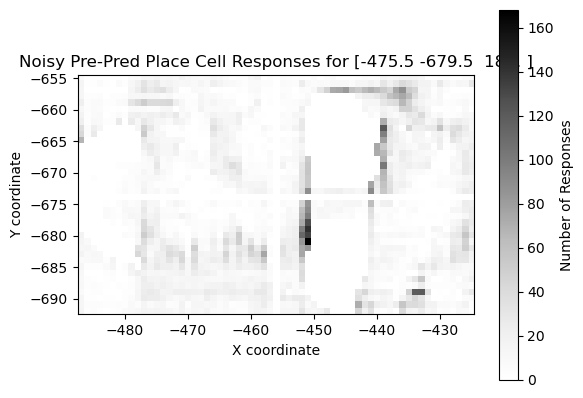

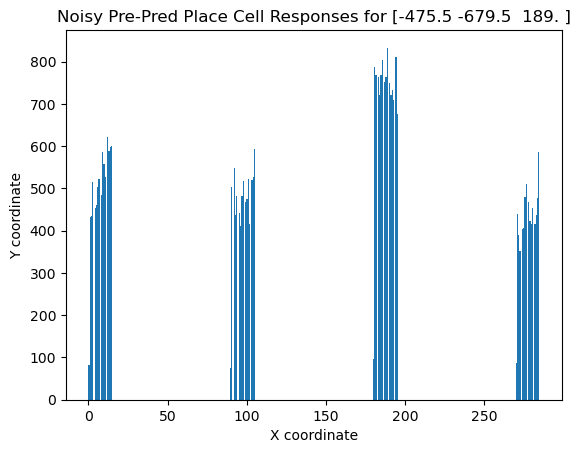

In [61]:
# Plot some individual place fields

idx = 10
latent = all_latents[idx]
coord = pred_coords[idx]

print(f'Actual coords: {coord}')

firings = np.array(list(get_activations(latent)))[..., :2]
#print(firings)

x_min, x_max = -487.5, -424.5
z_min, z_max = -692.5, -654.5

heatmap, xedges, yedges = np.histogram2d(firings[:,0], firings[:,1], bins=(63, 38), range=[[x_min + 1, x_max - 1], [z_min + 1, z_max - 1]])

plt.imshow(heatmap.T, extent=[x_min, x_max, z_min, z_max], origin='lower', cmap='Greys', interpolation='nearest')
plt.colorbar(label='Number of Responses')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Noisy Pre-Pred Place Cell Responses for {coord}')
plt.show()
plt.savefig('noisy-prepred-example-placefield.png', dpi=300)
plt.close()

firings = np.array(list(get_activations(latent)))[..., -1]
#print(firings)

plt.hist(firings, bins=360)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Noisy Pre-Pred Place Cell Responses for {coord}')
plt.show()
plt.savefig('noisy-prepred-example-yaw-field.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

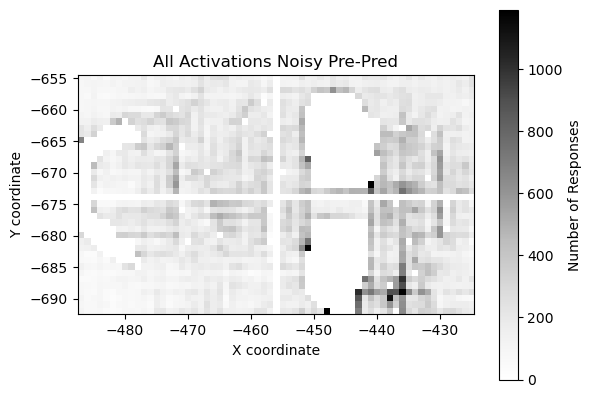

In [62]:
x_min, x_max = -487.5, -424.5
z_min, z_max = -692.5, -654.5

total_activations = [pos for actives in activations_dict for pos in actives]

coordinates = np.array(total_activations)

heatmap, xedges, yedges = np.histogram2d(coordinates[:,0], coordinates[:,1], bins=(63, 38), range=[[x_min+1, x_max-1], [z_min+1, z_max-1]])

# Plot the heatmap
plt.imshow(heatmap.T, extent=[x_min, x_max, z_min, z_max], origin='lower', cmap='Greys', interpolation='nearest')
plt.colorbar(label='Number of Responses')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('All Activations Noisy Pre-Pred')
plt.show()
plt.savefig('noisy-prepred-total-placefield.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()